In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        print(f"Tempo: {t}")
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        if isinstance(t, float):
             rho_vector[0][int(round(t,0))+r] = pt[0][0]
             rho_vector[1][int(round(t,0))+r] = pt[0][1]
             rho_vector[2][int(round(t,0))+r] = pt[1][0]
             rho_vector[3][int(round(t,0))+r] = pt[1][1]
             r += 1
        else:
            rho_vector[0][t] = pt[0][0]
            rho_vector[1][t] = pt[0][1]
            rho_vector[2][t] = pt[1][0]
            rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        # if 1/2*(1+rt[2][0]) > 0.9995:
        #     distance_vector.pop()
        #     fx_vector.pop()
        #     fy_vector.pop()
        #     fz_vector.pop()
        #     fid_vector.pop()
        #     fid_autores.pop()
        #     resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        #     u[0] = resultado_algoritmo_genetico[0]
        #     u[1] = resultado_algoritmo_genetico[1]
        #     u[2] = resultado_algoritmo_genetico[2]
        while 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            aas[-1] = ((u[0],u[1],u[2]))
        
        if D > 10**(-3):
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
        else:
            h = 0.0005
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            
            aas.append((u[0],u[1],u[2]))
            t += 0.5
        Ut = Uto

    print(f"O rho gerado foi: {pt}") 
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Tempo: 0
Tempo: 1
Tempo: 2
Tempo: 3
Tempo: 4
Tempo: 5
Tempo: 6
Tempo: 7
Tempo: 8
Tempo: 9
Tempo: 10
Tempo: 11
Tempo: 12
Tempo: 13
Tempo: 14
Tempo: 15
Tempo: 16
Tempo: 17
Tempo: 18
Tempo: 19
Tempo: 20
Tempo: 21
Tempo: 22
Tempo: 23
Tempo: 24
Tempo: 25
Tempo: 26
Tempo: 27
Tempo: 28
Tempo: 29
Tempo: 30
Tempo: 31
Tempo: 32
Tempo: 33
Tempo: 34
Tempo: 35
Tempo: 36
Tempo: 37
Tempo: 38
Tempo: 39
Tempo: 40
Tempo: 41
Tempo: 42
Tempo: 43
Tempo: 44
Tempo: 45
Tempo: 46
Tempo: 47
Tempo: 48
Tempo: 49
Tempo: 50
Tempo: 51
Tempo: 52
Tempo: 53
Tempo: 54
Tempo: 55
Tempo: 56
Tempo: 57
Tempo: 58
Tempo: 59
Tempo: 60
Tempo: 61
Tempo: 62
Tempo: 63
Tempo: 64
Tempo: 65
Tempo: 66
Tempo: 67
Tempo: 68
Tempo: 69
Tempo: 70
Tempo: 71
Tempo: 72
Tempo: 73
Tempo: 74
Tempo: 75
Tempo: 76
Tempo: 77
Tempo: 78
Tempo: 79
Tempo: 80
Tempo: 81
Tempo: 82
Tempo: 83
Tempo: 84
Tempo: 84.5
Tempo: 85.0
Tempo: 85.5
Tempo: 86.0
Tempo: 86.5
Tempo: 87.0
Tempo: 87.5
Tempo: 88.0
Tempo: 88.5
Tempo: 89.0
Tempo: 89.5


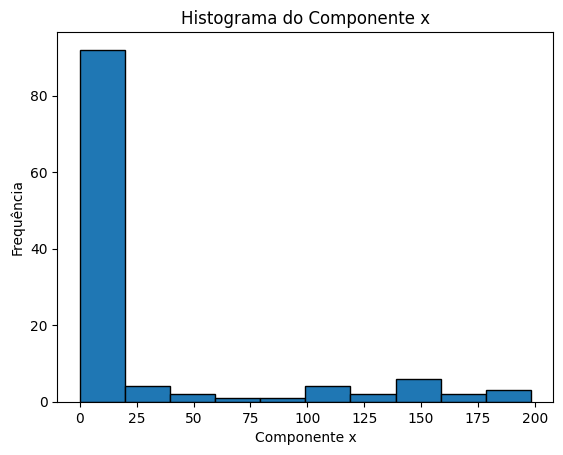

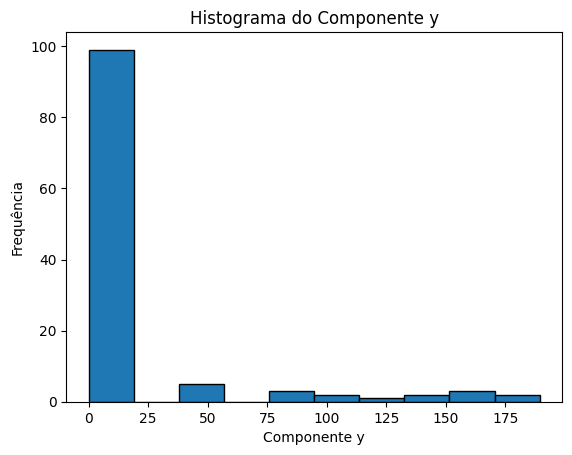

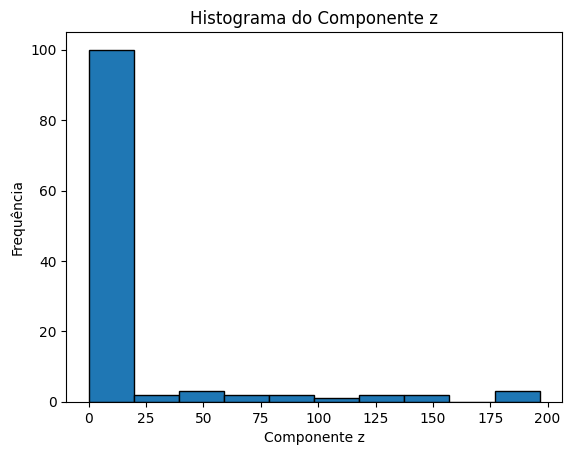

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9989037629989402
Estados: (0.9994392999691641+4.303733638281453e-09j)
Distância: 0.00010749210886034432
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[np.clongdouble('0.50014465186685759925+0j'),
 np.clongdouble('0.49963242814614640595-0.0002055079536467281134j'),
 np.clongdouble('0.49966257527630046983-7.1094019383623993127e-08j'),
 np.clongdouble('0.4994913388556196763-7.0845897415615510534e-08j'),
 np.clongdouble('0.49898015640557723277+1.5059277460064884063e-05j'),
 np.clongdouble('0.57503802758564494664+0.0003503515903037026839j'),
 np.clongdouble('0.5750303066947224909+0.00016169373979206881692j'),
 np.clongdouble('0.54161236035425738323-4.9456909905108611014e-05j'),
 np.clongdouble('0.6727703079713549078+3.6078947089002892045e-05j'),
 np.clongdouble('0.6733633638492539375+9.677367891614565505e-05j'),
 np.clongdouble('0.673888901154631036-3.15761945845310274e-05j'),
 np.clongdouble('0.6736217442166745511-0.00018403632129152418538j'),
 np.clongdouble('0.6736830014458712048-2.399217680616694916e-12j'),
 np.clongdouble('0.7444309194427619651-0.0001960448405733028492j'),
 np.clongdouble('0.7453748811264363325-1.1029125462171609376

In [23]:
fid_autores

[np.float64(0.3323716002916428),
 np.float64(0.32980038863190286),
 np.float64(0.3297683198339697),
 np.float64(0.3297623732087355),
 np.float64(0.3061895590198158),
 np.float64(0.27234357613263277),
 np.float64(0.2507740420293793),
 np.float64(0.2506193952742542),
 np.float64(0.2664173863998705),
 np.float64(0.2666590796197053),
 np.float64(0.26675611247408304),
 np.float64(0.32742778309810666),
 np.float64(0.378100696795292),
 np.float64(0.4379173661492806),
 np.float64(0.43879187605104003),
 np.float64(0.6030663225958414),
 np.float64(0.7414718629812858),
 np.float64(0.8842397860289296),
 np.float64(0.8842480291852018),
 np.float64(0.8842257334448208),
 np.float64(0.9156030773643118),
 np.float64(0.9165731335880699),
 np.float64(0.916549625381164),
 np.float64(0.9217427779035362),
 np.float64(0.9217433440315643),
 np.float64(0.9217613126451475),
 np.float64(0.9481790912223717),
 np.float64(0.9512873640096925),
 np.float64(0.9513095035834138),
 np.float64(0.9513419732161915),
 np.flo

In [24]:
rho_vector

array([[0.5       +0.00000000e+00j, 0.49963221+0.00000000e+00j,
        0.49945755+0.00000000e+00j, ..., 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.499995  +0.00000000e+00j, 0.49998986+4.50208034e-06j,
        0.49998455-3.85112672e-04j, ..., 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.499995  +0.00000000e+00j, 0.49998986-4.50208034e-06j,
        0.49998455+3.85112672e-04j, ..., 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.5       +0.00000000e+00j, 0.50036779+0.00000000e+00j,
        0.50054245+0.00000000e+00j, ..., 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j]])

In [25]:
distance_vector

[np.float64(7.988426176739125),
 np.float64(7.957152344757466),
 np.float64(7.9567608703299175),
 np.float64(7.956689699686216),
 np.float64(7.642428846617155),
 np.float64(7.0364059855371766),
 np.float64(6.202269037875205),
 np.float64(6.183533873420016),
 np.float64(5.108127794053271),
 np.float64(5.101379981877289),
 np.float64(5.09853061647924),
 np.float64(4.068845791288009),
 np.float64(3.5170801528151303),
 np.float64(2.993552077163141),
 np.float64(2.9864417229255444),
 np.float64(1.8801266107952335),
 np.float64(1.1401806561466346),
 np.float64(0.48088557789889563),
 np.float64(0.48074076900443924),
 np.float64(0.4807287891250013),
 np.float64(0.3486964776785857),
 np.float64(0.34452469393302704),
 np.float64(0.34451611791456527),
 np.float64(0.322447818601444),
 np.float64(0.322337215394423),
 np.float64(0.3221530611751755),
 np.float64(0.2114782865455515),
 np.float64(0.19881791602782214),
 np.float64(0.19862294167147926),
 np.float64(0.19838102509676298),
 np.float64(0.198

In [26]:
fx_vector

[np.float64(107.16775618112717),
 np.float64(137.1652998276843),
 np.float64(-0.03139829221085163),
 np.float64(-0.03140500514049837),
 np.float64(-0.012215351355155644),
 400,
 np.float64(-0.003830267873390076),
 np.float64(-0.003541535037385844),
 400,
 np.float64(2.4395817931127284),
 np.float64(1.0137011389292148),
 np.float64(-0.0008664352907176533),
 np.float64(-0.0004225606017741264),
 np.float64(143.94406733707496),
 np.float64(2.2407112517111036),
 400,
 np.float64(0.0009670250221983236),
 np.float64(233.18085287198278),
 np.float64(0.12184595943835205),
 np.float64(0.001194714653001561),
 np.float64(92.37751268275458),
 np.float64(0.0017630645847183685),
 np.float64(0.0017716426923173366),
 np.float64(38.98596704545625),
 np.float64(0.0025349871501492934),
 np.float64(0.002534984080143718),
 np.float64(0.0018321807310077145),
 np.float64(27.492032811970308),
 np.float64(0.003771791327026488),
 np.float64(0.0037809322647389763),
 np.float64(0.005686654955433844),
 np.float64(0

In [27]:
fy_vector

[np.float64(0.0),
 np.float64(0.35043148537756647),
 np.float64(0.34688687259372186),
 np.float64(0.34294878535651363),
 np.float64(-0.1734142636375956),
 np.float64(0.3588544857966806),
 np.float64(-0.023774551868197186),
 np.float64(77.25514842669767),
 np.float64(-0.060833539741326784),
 np.float64(-0.06417054624246187),
 np.float64(-0.06474515344227331),
 np.float64(-0.004493393791075543),
 np.float64(-0.0014167221935639878),
 np.float64(-0.00028845600895529433),
 np.float64(-0.0002675572326404365),
 np.float64(0.004256298900501929),
 np.float64(0.0034555908326843656),
 np.float64(0.003836628955712167),
 np.float64(0.00368057875045095),
 np.float64(0.011352038939846858),
 np.float64(0.004082359361990973),
 np.float64(17.392556538260525),
 np.float64(0.031160990482217717),
 np.float64(0.012773163117770719),
 np.float64(0.012630135982298016),
 np.float64(0.012636431954206016),
 np.float64(0.007552773772634731),
 np.float64(0.012940260544939556),
 np.float64(3.4929296830984584),
 np.f

In [28]:
fz_vector

[np.float64(0.0),
 np.float64(-0.03928912257902362),
 np.float64(0.7808458749749954),
 np.float64(-0.002008303337691246),
 400,
 np.float64(-0.006248430694964133),
 400,
 np.float64(-0.004784234274757707),
 np.float64(-0.0019189406663143057),
 np.float64(-0.001883289784225593),
 np.float64(-0.0018778839052217189),
 400,
 np.float64(222.3993945456193),
 np.float64(-0.00010489735213650074),
 np.float64(-9.68087783920724e-05),
 np.float64(0.0005282588900637025),
 np.float64(288.95833810547646),
 np.float64(0.0008391469243586399),
 np.float64(0.0008469929657486447),
 np.float64(0.0008471985118014226),
 np.float64(0.0005563154198792624),
 np.float64(0.0005976094401313785),
 np.float64(0.0005986100151596992),
 np.float64(0.0005526639534248264),
 np.float64(0.06891411220718756),
 np.float64(0.11691343848432037),
 np.float64(69.8812799567429),
 np.float64(0.0004550953850140186),
 np.float64(0.0004623252894862919),
 np.float64(0.19338942814454296),
 np.float64(0.0004627959357406186),
 np.float6

In [29]:
a

[(np.float64(107.16775618112717), np.float64(0.0), np.float64(0.0)),
 (np.float64(31.974322935693444),
  np.float64(0.0),
  np.float64(1.0339406540725504e-14)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.24879218175057866)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.011379049350357728)),
 (np.float64(0.0), np.float64(0.0), np.float64(144.0769415306895)),
 (np.float64(172.91569402148014),
  np.float64(1.68049409841473e-285),
  np.float64(2.9081935675831827e-24)),
 (np.float64(6.274677177242831e-62),
  np.float64(0.0),
  np.float64(102.82226404021122)),
 (np.float64(4.455561038200962e-11),
  np.float64(51.19486109279499),
  np.float64(0.0)),
 (np.float64(152.40591673848377), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.18956375018073918), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.07892478017165844),
  np.float64(3.6160096581113075e-221),
  np.float64(3.519952551152617e-123)),
 (np.float64(0.0), np.float64(0.0), np.float64(196.4802660889743)),
 (np.float64(0.0),
